# Exploring rainfall driven hydrographs with Landlab
This notebook was developed from code written by Jordan Adams as part of her PhD disseration at Tulane University. This notebook was created by Nicole Gasparini at Tulane University.

<hr>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

**What is this notebook?**

This notebook illustrates the importance of watershed shape and rainfall intensity and duration on the characteristics of hydrographs. 

To clearly contrast landscape shape, this notebook uses two synthetic landscapes, or landscapes produced using a landscape evolution model. One landscape is square (length = width) and one is rectangular (length = 4*width). Both landscapes have a drainage area of 36 km$^2$ and a cell size of 30 m.

Overland flow is modeled as a diffusive approximation of the shallow water equation. (If you do not understand what that means, you can still learn from this notebook.) No infiltration is modeled. Rain falls on the landscape and flows downhill, driving overland flow and a hydrograph at every location on the landscape. In this notebook, we track the hydrograph at three points in the watershed.

Before using this notebook you should have learned about overland flow and a hydrograph. You should know the terms rainfall intensity and duration, as well as peak discharge, hydrograph time to peak, rising limb, and falling limb. For example, these concepts are covered in Chapter 10 of:

Dingman, S.L., 2015. Physical hydrology, third edition. Waveland press.

More background on the model used here and the results presented can be found in:

Adams, J.M., Gasparini, N.M., Hobley, D.E., Tucker, G.E., Hutton, E.W., Nudurupati, S.S. and Istanbulluoglu, E., 2017. The Landlab v1. 0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds. Geoscientific Model Development.

The code used in this exercise is taken from the above Adams et al., (2017) reference.

**What will you do?** 

You will run this model several times, changing the rainfall characteristics or watershed on which flow is routed. You will generate hydrographs and learn how different parameters affect hydrograph characteristics.

Start at the top by reading each block of text and sequentially running each code block (put your curser in a code block and type shift - enter OR got to the _Cell_ pulldown menu at the top and choose _Run Cells_). 

Remember that you can always go to the _Kernel_ pulldown menu at the top and choose _Restart & Clear Output_ or _Restart & Run All_ if you change things and want to start afresh. 

**Questions to answer before running this notebook.**

1. Do you think that watershed shape affects hydrograph shape? Consider two watersheds, one that is square and one that is rectangular with a width to length ratio of 1 to 4. Both watersheds have the same drainage area. If the same amount of rain falls uniformly across each landscape, will it affect the time to peak and peak discharge at the outlet?
2. Do you think that the rainfall intensity impacts the time to peak and peak discharge at a watershed outlet? If so, how?
3. Do you think that the rainfall duration impacts the time to peak and peak discharge at a watershed outlet? If so, how?

**Now on to the code.**
* Below we import Landlab components, functions for importing data, numpy and plotting tools. You should not need to change this.

In [1]:
## Code Block 1
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from landlab.components import FlowAccumulator, OverlandFlow, PriorityFloodFlowRouter
from landlab.io import esri_ascii

Now we import the data for the watershed we want to route flow on. **You will want to change this code block for the different scenarios. Initially you do not need to change anything.**

* The user can change the `basin_flag` to equal `Square` or `Long` depending on the watershed to run.
  * The outlet link for each watershed was pretermined for plotting purposes.
* The user can also choose which storm to run. 
  * `Base` has an intensity of 5.0 mm/hr, with a duration of 2 hr.
  * `HigherIntensity` has an intensity of 10.0 mm/hr, with a duration of 1 hr.
  * `LongerDuration` has an intensity of 2.5 mm/hr, with a duration of 4 hr.

In [4]:
## Code Block 2

basin_flag = "Long"  # 'Square' or Long'
storm_flag = "LongerDuration"  # 'Base' or'HigherIntensity' or 'LongerDuration'

## If the basin flag matches one of the two select basins,
## below will set the filename which to read the DEM from and
## the outlet link and upstream link to sample discharge values
## from for plotting.

if basin_flag == "Square":
    watershed_dem = "Square_TestBasin.asc"
    ## Reading in the DEM given the filename from above
    with open(watershed_dem) as fp:
        rmg = esri_ascii.load(fp, name="topographic__elevation", at="node")
    outlet_node_to_sample = 300
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    upstream_node_to_sample = 28689
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    midstream_node_to_sample = 9102
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][3]
##else:
    ##watershed_dem = "Long_TestBasin.asc"
    ## Reading in the DEM given the filename from above
   ## with open(watershed_dem) as fp:
   ##     rmg = esri_ascii.load(fp, name="topographic__elevation", at="node")
   ## outlet_node_to_sample = 150
   ## outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    ##upstream_node_to_sample = 33859
   ## upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
   ## midstream_node_to_sample = 14658
   ## midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][2]
else: 
    watershed_dem = "saucon_ws_4_15.txt"
    ## Reading in the DEM given the filename from above
    with open(watershed_dem) as fp:
        rmg = esri_ascii.load(fp, name="topographic__elevation", at="node")
        
    outlet_node_to_sample = 39271
    outlet_link_to_sample = rmg.links_at_node[outlet_node_to_sample][3]
    upstream_node_to_sample = 9099
    upstream_link_to_sample = rmg.links_at_node[upstream_node_to_sample][3]
    midstream_node_to_sample = 24866
    midstream_link_to_sample = rmg.links_at_node[midstream_node_to_sample][3]
    with open(watershed_dem) as fp:
        info, data = esri_ascii.lazy_load(fp, name="topographic__elevation", at="node")


## The Flow Router calculates drainage area, which is helpful for
## calculating equilibrium discharge, which we illustrate later.
fr = PriorityFloodFlowRouter(rmg)
#fr = FlowAccumulator(rmg)  # Instantiate flow router
fr.run_one_step()  # Drainage area calculated

Now we set the boundary conditions, initialize the process components, and set the appropriate storm parameters.

[39271]
[39272]


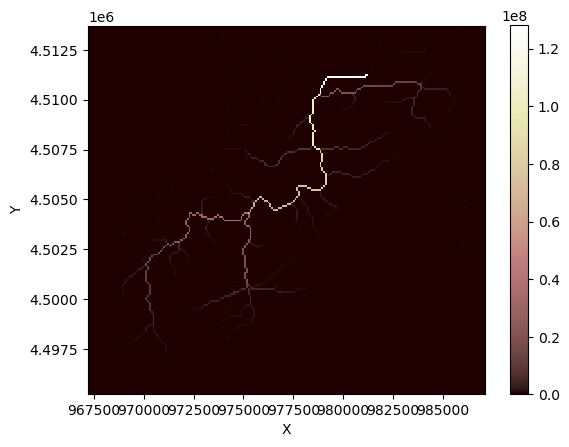

In [7]:
da = rmg.at_node["drainage_area"]
da_sorted = np.sort(da)[::-1]
Station_da = da_sorted[1]
Outlet_da = da_sorted[0]
Station_node = np.where(da == Station_da)
Outlet_node = np.where(da == Outlet_da)
Station_node = Station_node[0]
Outlet_node = Outlet_node[0]
#gauge_node = np.where(da_sorted == da_sorted[1])
# gauge_node
#gauge_node = np.where(da_sorted == da_sorted[-2])
#gauge_node
print(Station_node)
print(Outlet_node)
rmg.imshow("drainage_area")


In [9]:
## Code Block 3

## Set boundary coditions on the grid
#rmg.set_watershed_boundary_condition(rmg.at_node["topographic__elevation"])
rmg.set_nodata_nodes_to_closed(rmg.at_node["topographic__elevation"], -9999.0)
rmg.set_status_at_node_on_edges(right=4, top=4, left=4, bottom=4)
rmg.status_at_node[45303] = rmg.BC_NODE_IS_FIXED_VALUE
#rmg.status_at_node[outlet_node] = rmg.BC_NODE_IS_FIXED_VALUE
## instantiate OverlandFlow object
rmg.add_zeros("surface_water__depth", at="node")
of = OverlandFlow(rmg, alpha=0.45, steep_slopes=True)

## HelloAssign storm conditions based on flag in Code Block 2
if storm_flag == "Base":
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10**-7)
    storm_duration = 7200.0
elif storm_flag == "HigherIntensity":
    starting_precip_mmhr = 10.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10**-7)
    storm_duration = 3600.0
elif storm_flag == "LongerDuration":
    starting_precip_mmhr = 2.5
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10**-7)
    storm_duration = 14400.0

Before we go further, let's pause to look at the landscape that we will be routing flow over.

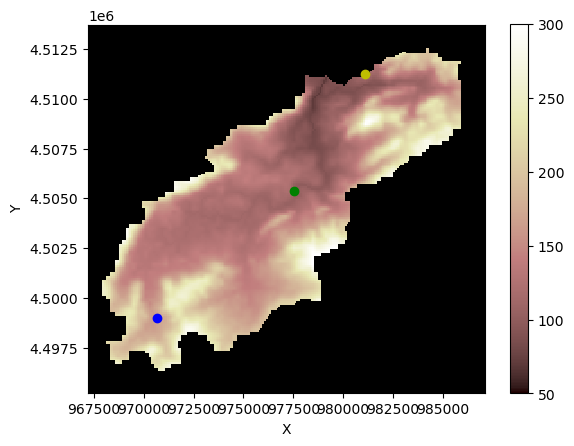

In [11]:
## Code Block 4

plt.figure(1)
# imshow_grid(rmg, z)  # plot the DEM
rmg.imshow("topographic__elevation", limits=(50, 300))
#rmg.at_node["topographic__elevation"][39028]= -9999.0
plt.plot(rmg.node_x[outlet_node_to_sample], rmg.node_y[outlet_node_to_sample], "yo")
plt.plot(rmg.node_x[upstream_node_to_sample], rmg.node_y[upstream_node_to_sample], "bo")
plt.plot(
    rmg.node_x[midstream_node_to_sample], rmg.node_y[midstream_node_to_sample], "go"
)

Initialize a few more parameters, and getting ready to run the time loop and save data for plotting.
  * Note that time is in *seconds*

In [ ]:
## Code Block 5

elapsed_time = 1.0  # s
model_run_time = 43200.0  # s

## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

## Setting initial fields...
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

Now the time loop that generates overland flow.

_Note_ On a 2016 MacBook Pro laptop the following code block can take ~ 5 minutes depending on the model set-up. It could take longer if multiple users are running at the same time using the Hydroshare platform.

In [ ]:
## Code Block 6

with tqdm(total=model_run_time) as pbar:
    while elapsed_time < model_run_time:
        # Setting the adaptive time step
        of.dt = of.calc_time_step()

        ## The storm starts when the model starts. While the elapsed time is less
        ## than the storm duration, we add water to the system as rainfall.
        if elapsed_time < (storm_duration):
            of.rainfall_intensity = starting_precip_ms
        else:  # elapsed time exceeds the storm duration, rainfall ceases.
            of.rainfall_intensity = 0.0

        of.run_one_step()  # Generating overland flow based on the deAlmeida solution.

        ## Append time and discharge to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time)
        q = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
        discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * rmg.dx)
        discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * rmg.dx)

        elapsed_time += of.dt

        pbar.update(of.dt)

Let's look at the data.

In [ ]:
## Code Block 7

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = starting_precip_ms * rmg.at_node["drainage_area"][outlet_node_to_sample]
midstream_eq_q = (
    starting_precip_ms * rmg.at_node["drainage_area"][midstream_node_to_sample]
)
upstream_eq_q = (
    starting_precip_ms * rmg.at_node["drainage_area"][upstream_node_to_sample]
)


## Plotting hydrographs and equilibrium discharge
plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "y-", label="outlet")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [outlet_eq_q, outlet_eq_q],
    "y--",
    label="outlet eq Q",
)
plt.plot(hydrograph_time, discharge_midstream, "g-", label="midstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [midstream_eq_q, midstream_eq_q],
    "g--",
    label="midstream eq Q",
)
plt.plot(hydrograph_time, discharge_upstream, "b-", label="upstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [upstream_eq_q, upstream_eq_q],
    "b--",
    label="upstream eq Q",
)

## Plot storm end and center of storm for reference
plt.plot(
    [storm_duration, storm_duration], [0, 100], "k-", linewidth=2, label="storm end"
)
plt.plot(
    [storm_duration / 2, storm_duration / 2], [0, 100], "k:", label="storm mid point"
)

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
title_text = "Hydrographs, Storm is " + storm_flag + ", Watershed is " + basin_flag
plt.title(title_text)
plt.axis([0, np.max(hydrograph_time), 0, 100])

If you have reached this point, you should have produced a plot of three hydrographs from different points on the square watershed, produced from overland flow driven by the base storm.

There are six scenarios to explore: two different watersheds and three different storms. Run all six scenarios by systematically changing the *basin_flag* and *storm_flag* in Code Block 2 and rerunning all of the following code blocks sequentially. Save the hydrograph plots for each scenario. Include those plots in a document that also contains your typed answers to each of the questions below. Answer all of the questions with complete sentences. Try to be as specific and as quantitative as you can. (e.g. You can compare times to peak discharge and peak discharge values among the scenarios.) You are encouraged to discuss the results of the models with your classmates, but the text you turn in must be your own thoughts and words.

1. Consider only the three stroms run on the square watershed. What aspects of the hydrograph change at the outlet as the storm gets longer or more intense? Are there aspects of the outlet hydrograph that are not sensitive to the storm duration or intensity? Do the midstream and upstream hydrographs exhibit the same sensitivity to storm duration and intensity? If yes, why? If no, why not?

2. Now, consider only the three stroms run on the long watershed. What aspects of the hydrograph change at the outlet as the storm gets longer or more intense? Are there aspects of the outlet hydrograph that are not sensitive to the storm duration or intensity? Do the midstream and upstream hydrographs exhibit the same sensitivity to storm duration and intensity? If yes, why? If no, why not?

3. Now compare the results between the two different basin shapes. Compare only between similar points (e.g. square outlet to long outlet) and between the same storm characteristics. Does watershed shape affect hydrograph shape? If so, how? If so, does it impact all locations in the same manner? Do different storm charactersitics exaggerate the differences between the different watersheds?

4. Go back and look at your answers to the questions you answered before running the models. Do the model results match your intuition? If not, do you think your intuition was wrong, or the model was wrong, or both? Remember, models are helpful for learning but they are highly simplified representations of the real world. Wihtout knowing the details of the model, does it seem like something is missing from your model results?

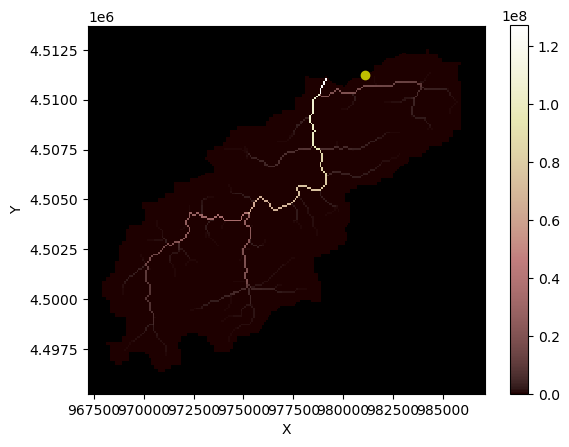

In [13]:

rmg.imshow("drainage_area")
#rmg.imshow("surface_water__depth")
plt.plot(rmg.node_x[outlet_node_to_sample], rmg.node_y[outlet_node_to_sample], "yo")





In [ ]:
da = rmg.at_node["drainage_area"]
da_sorted = np.sort(da)[::-1]
Station_da = da_sorted[1]
Station_node = np.where(da == Station_da)
Station_node = Station_node[0]
#gauge_node = np.where(da_sorted == da_sorted[1])
# gauge_node
#gauge_node = np.where(da_sorted == da_sorted[-2])
#gauge_node
Station_node

In [ ]:
rmg.nodes

In [ ]:
da